## 출처:
https://github.com/ragulpr/wtte-rnn/blob/master/examples/keras/simple_example.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(n_timesteps, every_nth, n_repeats, noise_level, n_features, use_censored = True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(range(n)) for _ in range(every_nth)])
        events = events + np.array(range(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual
    
    tte_censored,not_censored,was_event,events,tte_actual = get_equal_spaced(n=n_timesteps,every_nth=every_nth)

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train      = not_censored.T.reshape(n_sequences,n_timesteps,1)
    x_train      = was_event.T.reshape(n_sequences,n_timesteps,1)
    tte_censored = tte_censored.T.reshape(n_sequences,n_timesteps,1)
    y_train      = np.append(tte_censored,u_train,axis=2) # (n_sequences,n_timesteps,2)

    u_test       = np.ones(shape=(n_sequences,n_timesteps,1))
    x_test       = np.copy(x_train)
    tte_actual   = tte_actual.T.reshape(n_sequences,n_timesteps,1)
    y_test       = np.append(tte_actual,u_test,axis=2) # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible. 
    # More noise->more fun so add noise to the training data:
    
    x_train = np.tile(x_train.T,n_repeats).T
    y_train = np.tile(y_train.T,n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0],x_train.shape[1],n_features])
    x_test_new = np.zeros([x_test.shape[0],x_test.shape[1],n_features])
    for f in range(n_features):
        x_train_new[:,:,f] = x_train[:,:,0]
        x_test_new[:,:,f]  = x_test[:,:,0]
        
    x_train = x_train_new
    x_test  = x_test_new
    
    # xtrain is signal XOR noise with probability noise_level
    # noise의 형태가 1아니면 0이다.
    noise = np.random.binomial(1,noise_level,size=x_train.shape)
    x_train = x_train+noise-x_train*noise
    return y_train,x_train, y_test,x_test,events

In [3]:
# 200번의 타임스텝에서 
n_timesteps    = 50
# 80번 마다 사건이 발생
n_sequences = every_nth = 5
# 설명변수는 하나
n_features = 1
#
n_repeats = 100
# 잡음을 주는 정도
noise_level = 0.005
use_censored = True

y_train,x_train, y_test,x_test,events = get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored)

* **x_train** => (num_repeats, 시그널[0,1]) : time_steps 에 따른 시그널을 보여준다.
* **y_train** => (num_repeats, 간격, censored 여부) : 1이면 non_censored 아니면 0이다. 간격이 0인 지점이 바로 사건이 발생한 지점이다.
* **events** => (time_steps, every_nth) : events[:,0] 은 이벤트가 실제 발생한 지점을 가리키는 벡터로, x_train[0], y_train[0]과 한 그룹으로 묶인다.

# 아래의 플롯에 대한 설명

1. x_test에 특정 간격으로 나뉘어져 있는 것을 볼 수 있다. y축은 높이 5이고(시차,lagged) x축은 길이가 50(사건의 길이, deterministic event indicator)이다. 

2. y_test를 보면 다양한 색깔이 균일한 간격으로 나뉘어져 있음을 할 수 있다. 이는 이벤트까지 얼마나 많은 기간이 남았는지를 보여준다.

3. 맨 마지막 플롯은 censored 여부를 보여준다. 

test shape (5, 50, 1) (5, 50, 2)


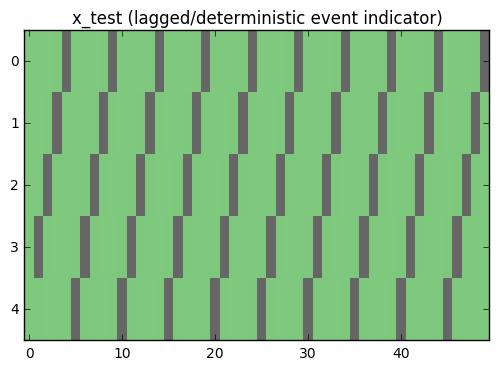

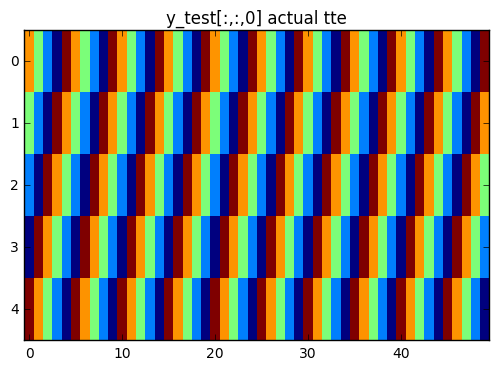

In [4]:
print('test shape',x_test.shape,y_test.shape)
plt.imshow(x_test[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_test (lagged/deterministic event indicator)')
plt.show()
plt.imshow(y_test[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('y_test[:,:,0] actual tte')
plt.show()

train shape (500, 50, 1) (500, 50, 2)


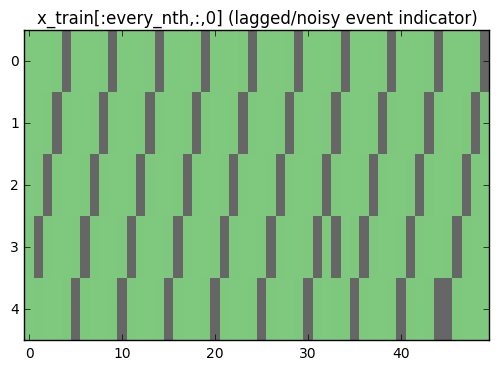

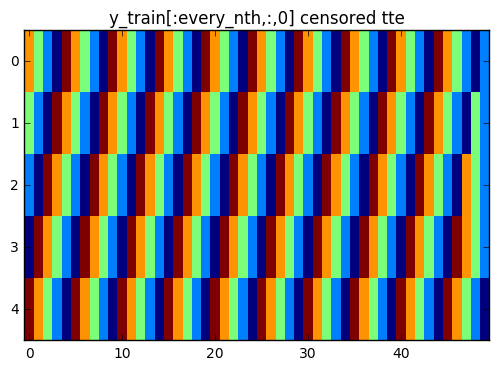

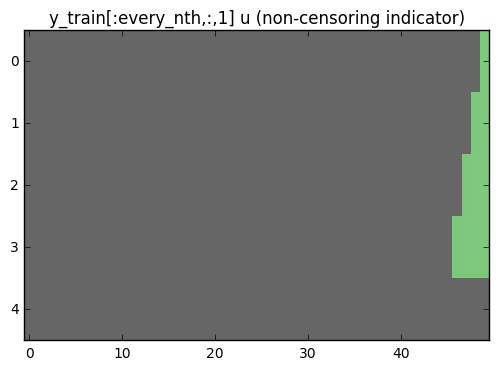

In [5]:
print('train shape',x_train.shape,y_train.shape)
plt.imshow(x_train[:every_nth,:,:].mean(axis=2),interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_train[:every_nth,:,0] (lagged/noisy event indicator)')
plt.show()
plt.imshow(y_train[:every_nth,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('y_train[:every_nth,:,0] censored tte')
plt.show()
plt.imshow(y_train[:every_nth,:,1],interpolation="none",cmap='Accent',aspect='auto')
plt.title('y_train[:every_nth,:,1] u (non-censoring indicator)')
plt.show()

Example TTEs


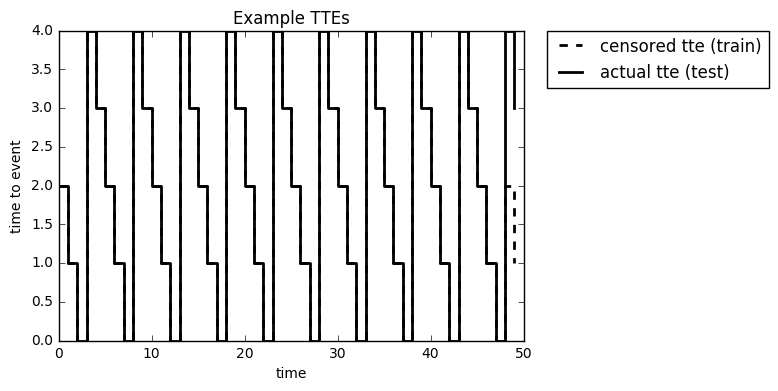

In [6]:
print('Example TTEs')
plt.plot(y_train[every_nth//4,:,0],label='censored tte (train)',color='black',linestyle='dashed',linewidth=2,drawstyle='steps-post')
plt.plot(y_test[every_nth//4,:,0],label='actual tte (test)',color='black',linestyle='solid',linewidth=2,drawstyle='steps-post')

plt.xlim(0, n_timesteps)
plt.xlabel('time')
plt.ylabel('time to event')
plt.title('Example TTEs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Things to try out:
* have fun with data paramaters:
    * every_nth to control event frequency 
    * noise_level to make it more noisy 
    * n_timesteps 
    * n_features to get more noisy input
* Generate more interesting temporal relationships
* Here we use the smallest possible GRU. Try different learning rates, network architectures, initializations. 
* Try Implementing multivariate distributions, other distributions, data pipelines etc.
* Invent better output activation layer
* Invent ways to overcome instability with lots of censoring
* ETC and have fun

* 초기값을 라이클리후드로 설정한다.
* 아래 예제의 uncensored data의 비율은 0.96이다.

## 구현하기 전에 몇 가지 개념을 간략히 정리하고 들어가자

1. 생존함수 $S(t)=P(T>t),\quad T\quad is\quad random\quad time$   : 생존시간이 t보다 클 확률

2. 위험함수 ${\displaystyle \lambda(t)=\lim _{dt\rightarrow 0}{\frac {\Pr(t\leq T<t+dt)}{dt\cdot S(t)}}={\frac {f(t)}{S(t)}}=-{\frac {S'(t)}{S(t)}}.}$

3. 누적위험함수 ${ \Lambda (t)=\int _{ 0 }^{ t } \lambda (u)\, du }$

4. ${Y}_{t}=(T-t)|(T>t)$  일 때 다음의 $F$를 정의할 수 있다.$F(t,s)=P({ Y }_{ t }\le s)=P(T\le t+s|T>t)=1-{ exp(-(Λ(t+s)-Λ(t))) }$

5. $F(t,s)=1-S(t,s)$이다.

6. **Recurrent CHF(RCHF)** = $R(t, s) = R(0, t + s) − R(0, t)$ <=> $  R(t, s) = \Lambda(t + s) − \Lambda(t)$

## Tensorflow로 구현해보자.

### RNN 구성

입력은 과거의 기록을 이진화한 시계열이다.
출력은 Weibull 분포의 두 가지 모수인 $\alpha$ 와 $\beta$이다.

### Weibull 분포는 지수분포의 일반화 분포로 생각하면 쉽다. 2개의 모수 $\alpha$와 $\beta$ 를 같는다.
**$\alpha$**는 다음 사건이 얼마나 빨리 일어날지를 의미한다.

**$\beta$**는 다음 사건이 얼마나 확실하게 일어나는지를 의미한다.

## tensorflow로 못하겠다.

In [42]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras.callbacks import History

import wtte.weibull as weibull
import wtte.wtte as wtte

from wtte.wtte import WeightWatcher

In [7]:
# Paramaeters for output activation layer initialization.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:,:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
mean_u = np.nanmean(y_train[:,:,1])
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored: ',mean_u)

### Uncomment if you have varying length sequences that is nanpadded to the right:
# mask_value = -1.3371337 # Use some improbable but not nan-causing telltale value
# x_train[:,:,:][np.isnan(x_train)] = mask_value
# y_train[:,:,0][np.isnan(y_train[:,:,0])] = tte_mean_train
# y_train[:,:,1][np.isnan(y_train[:,:,1])] = 0.5
# sample_weights = (x_train[:,:,0]!=mask_value)*1.

init_alpha:  2.52681581202 mean uncensored:  0.96


In [10]:
history = History()
weightwatcher = WeightWatcher()

# Start building the model
# keras의 시작모드인듯.ㅎㅎ
model = Sequential()

# Dont need to specify input_shape=(n_timesteps, n_features) since keras uses dynamic rnn by default
# 첫번째 레이어 => GRU 모델 사용.
model.add(GRU(1, input_shape=(None, n_features),activation='tanh',return_sequences=True))

# 두번째 레이어
# Dense(2)는 2개의 hidden unit을 가지는 fully connected layer를 말한다.
model.add(Dense(2))

# 세번째 레이어
# Lambda를 구하는 함수.
model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":4.0}))

# WTTE_RNN의 loss를 별도로 지정해준다.
loss = wtte.loss(kind='discrete').loss_function

model.compile(loss=loss, optimizer=adam(lr=.01))
# model.compile(loss=loss, optimizer=adam(lr=.01),sample_weight_mode='temporal') # If varying length

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 1)           9         
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           4         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


C:\Users\SOHN\Anaconda3\lib\site-packages\wtte\wtte.py:83: UserWarning:             Using tensorflow backend and allowing high `max_beta_value` may lead to
            gradient NaN during training unless `K.epsilon()` is small.
            Call `keras.backend.set_epsilon(1e-08)` to lower epsilon             
  warnings.warn(message)


In [11]:
#모델 적합!!
model.fit(x_train, y_train,
          epochs=60, 
          batch_size=x_train.shape[0]//10, 
          verbose=1,
          validation_data=(x_test, y_test),
#           sample_weight = sample_weights # If varying length
          callbacks=[history,weightwatcher])

Train on 500 samples, validate on 5 samples
Epoch 1/60
500/500 [==============================] - 0s - loss: 1.8030 - val_loss: 1.8102
Epoch 2/60
500/500 [==============================] - 0s - loss: 1.7409 - val_loss: 1.7430
Epoch 3/60
500/500 [==============================] - 0s - loss: 1.6736 - val_loss: 1.6

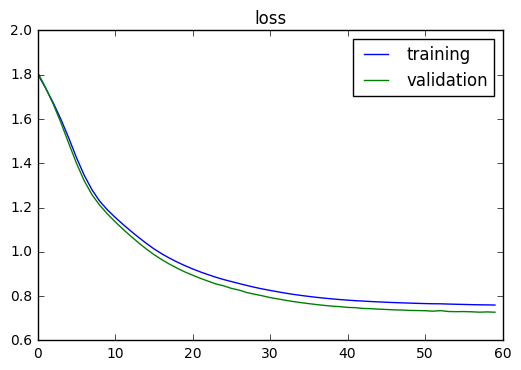

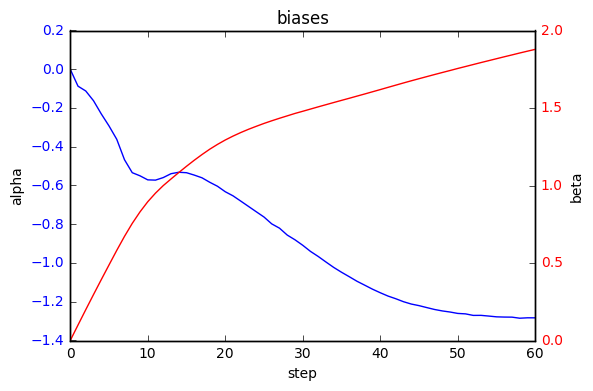

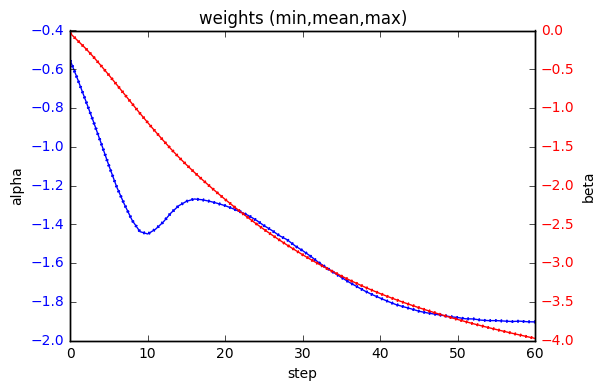

In [12]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

1. time_steps가 50이고 input_dim = 1인 자료를 넣어,
2. output_dim = 2인 와이블 분포의 모수를 얻게 되었다.

In [18]:
x_test.shape

(5, 50, 1)

In [17]:
predicted.shape

(5, 50, 2)

TESTING (no noise in features)
(each horizontal line is a sequence)
(5, 50, 2)


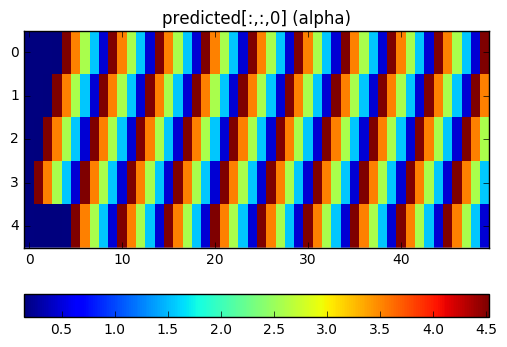

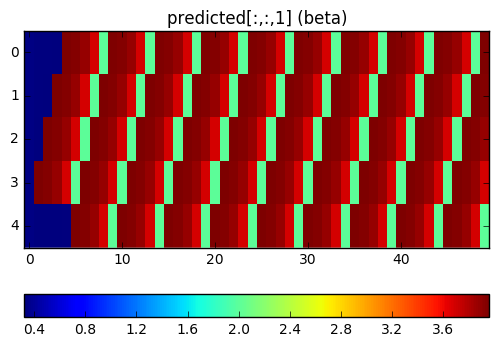

TRAINING (Noisy features)
(5, 50, 2)


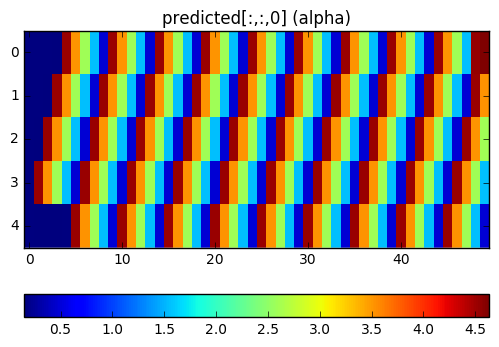

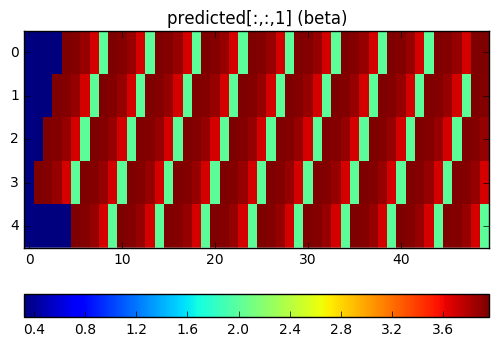

In [13]:
# Make some parametric predictions
print('TESTING (no noise in features)')
print('(each horizontal line is a sequence)')
predicted = model.predict(x_test)
print(predicted.shape)

plt.imshow(predicted[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,0] (alpha)')
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,1] (beta)')
plt.colorbar(orientation="horizontal")
plt.show()

print('TRAINING (Noisy features)')
predicted = model.predict(x_train[:every_nth,:,:])
print(predicted.shape)

plt.imshow(predicted[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,0] (alpha)')
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,1] (beta)')
plt.colorbar(orientation="horizontal")
plt.show()